# Grover's Algorithm

Grover's Algorithm is an algorithm to solve the unstructured search problem. That is, we have a function $f(x)$ where $f(x) = 1$ if $x$ is a solution, and $f(x) = 0$ if $x$ is not a solution.

Classicaly, if the search space (i.e. possible $x$) has $N$ elements, we need $O(N)$ queries to discover the solution because no guarantees are made about $f(x)$.

Grover's algorithm manages to solve the problem with $O(\sqrt N)$, despite not knowing nothing about $f(x)$. That quadratic speedup can be widely applied to many brute-force algorithms.

In real life, the search problem might be:

* Travelling salesman problem
* Finding the password for an encrypted file
* Boolean satisfiability problem

In this notebook, we will solve the "Needle in a Haystack" problem: we will try to find a single solution string $s$ among a big search space.

We will cover the 3 steps of Grover's algorithm:

### Step 1

Generate the superposition state:

$$
|\psi\rangle = \frac{1}{\sqrt 2 ^ {n}}\sum_{x \in \{0, 1\}^{n}}|x\rangle
$$

And initialize the ancilla qubit to $\frac{|0\rangle - |1\rangle}{\sqrt 2}$.

### Step 2

Apply Grover's iteration $K$ times:

* Query the oracle. This is sometimes also called reflection around the solution.
* Invert about the mean. This is sometimes also called reflection around the superposition state.

### Step 3

Measure the qubits. $s$ will be the measurement with a high probability.

In [1]:
%matplotlib inline
from math import pi, sqrt
from qiskit import *

In [2]:
solution_string = "10101"
n = len(solution_string)
N = 2**n

## Multi-qubit Toffoli gate

To implement, the inversion about the mean, we need a Multi-qubit Toffoli gate. In Qiskit, that gate is available through:

```Python
circuit.mct(controls, target, ancillas, mode)
```

Notice that the mode influences how the circuit is built. For more information, read Qiskit's documentation. This time, we have opted to use the *noancilla* mode in order to have a circuit with no extra qubits. Notice that depending on the mode, more gates might be used (it is a trade-off after all).

For the curious, here is what a multi-qubit Toffoli gate looks like when decomposed into CNOTs and single qubit gates.

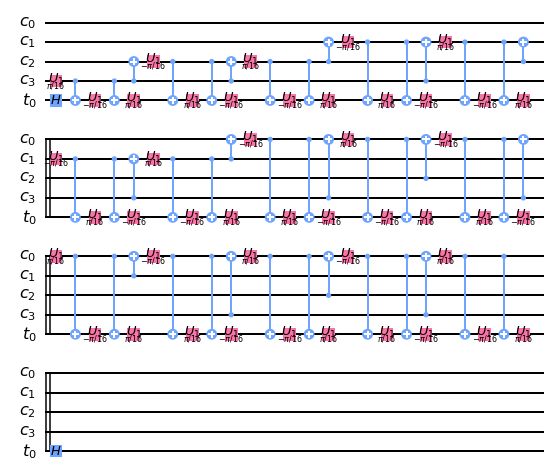

In [50]:
ex_c = QuantumRegister(n-1, name="c")
ex_t = QuantumRegister(1, name="t")
ex_circuit = QuantumCircuit(
    ex_c,
    ex_t,
)

ex_circuit.mct(ex_c, ex_t[0], None, mode="noancilla")

ex_circuit.draw(output="mpl", scale=0.3)

## Querying the oracle

To query the oracle, we need a working qubit to store $f(x)$. Thus, the oracle acts as $|x\rangle|0\rangle \rightarrow |x\rangle|f(x)\rangle$ and $|x\rangle|1\rangle \rightarrow |x\rangle|1 \oplus f(x)\rangle$.

On this implementation, we have opted to choose to implement the "Needle in a Haystack" problem. That is, there is a single solution $s$ among a big search space.

Mathematically, we will implement a function such that $f(x) = 1 \iff x = s$ and $f(x) = 0$ if $x \neq s$.

To implement $f$, we will use a multi-controlled Toffoli gate. We will $NOT$ all the bits that are 0 in $s$, apply the Toffoli gate, and then $NOT$ again to reverse the change in $x$. That circuit implements $f(x)$ as we described before, because the AND is only true when $x = s$. The following code does exactly that:

In [51]:
def oracle(circuit, solution_string):
        
        N = len(solution_string)
        controls = QuantumRegister(N)
        target = QuantumRegister(1)
        classical = ClassicalRegister(N)
        toffoli_circuit = QuantumCircuit(
            controls,
            target,
            classical,
            name="U_f",
        )
        
        for index, digit in enumerate(solution_string):
            if digit == "0":
                toffoli_circuit.x(index)
        
        toffoli_circuit.mct(controls, target[0], None, mode="noancilla")
        
        for index, digit in enumerate(solution_string):
            if digit == "0":
                toffoli_circuit.x(index)
        
        circuit.append(
            toffoli_circuit.to_instruction(),
            range(N+1)
        )

## Inversion about the mean

The inversion about the mean step is the crucial step in Grover's algorithm.

The idea of inversion about the mean is to amplify the amplitude of the solution, and to minimize the amplitude of nonsolutions. It can be seen as a process distributing the amplitudes from nonsolutions to the solution.

To implement the inversion about the mean in a quantum circuit, we:

* Apply Hadamard gates to all qubits
* Apply a multi-qubit Toffoli gate, with all qubits NOTed
* Apply again Hadamard gates to all qubits

In [52]:
def inversion_about_mean(circuit, N):
    
    controls = QuantumRegister(N)
    target = QuantumRegister(1)
    classical = ClassicalRegister(N)
    inversion_circuit = QuantumCircuit(
        controls,
        target,
        classical,
        name="U_ω",
    )
    
    # Apply Hadamards
    inversion_circuit.h(range(N))
    
    # Apply N-Qubit Toffoli Gate with NOTed Controls
    inversion_circuit.x(range(N))
    inversion_circuit.mct(controls, target[0], None, mode="noancilla")
    inversion_circuit.x(range(N))
    
    # Apply Hadamards again
    inversion_circuit.h(range(N))
    
    
    circuit.append(
        inversion_circuit.to_instruction(),
        range(N+1)
    )

In [53]:
def grover_iteration(circuit, solution_string, K):
    
    N = len(solution_string)
    for k in range(K):
        oracle(circuit, solution_string)
        inversion_about_mean(circuit, N)

## Number of steps

The number of queries needed to guess the solution by Grover's algorithm is:

$$
K \approx \frac{\pi \sqrt N}{4}
$$

The value of $K$ can be derived by the geometric and algebraic proofs of Grover's algorithm, that we will not discuss here. 

One important remark is: do not do more than $K$ iterations! Later on, we will see that it decreases the probability of finding the solution.

In [54]:
K = round(pi*sqrt(N)/4)
print(K)

4


## Bringing it all together

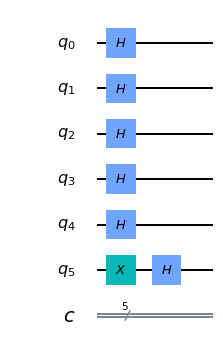

In [55]:
# Generate superposition state and initialize ancilla qubit
circuit = QuantumCircuit(n+1, n)
circuit.x(n)  # Working qubit must start as |1>
circuit.h(range(n+1))
circuit.draw(output="mpl")

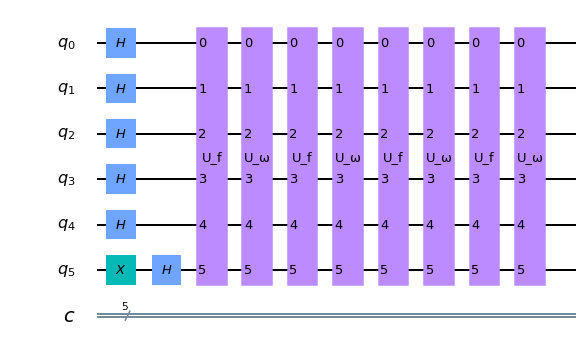

In [56]:
# Apply the Grover iteration K times
grover_iteration(circuit, solution_string, K)

circuit.draw(output="mpl")

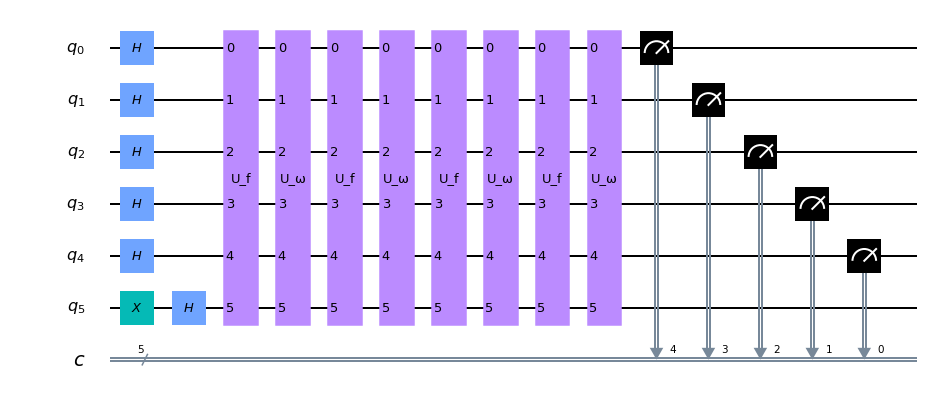

In [57]:
# Measure the state; the measurement will be the solution with high probability
circuit.measure(
    list(range(n)),
    list(reversed(range(n))),
)  # Qiksit measurements are done in reverse, so we reverse it to obtain the normal version 
circuit.draw(output="mpl", scale=0.8)

## Simulating

Now it is time to run the algorithm! Notice that Grover's algorithm finds the solution with high probability, so sometimes non-solutions show up.

However, it is very easy to deal with the case where it is not a solution: we just need to plug $f(x)$ to check if it is a solution. If it is not, we run the algorithm again.

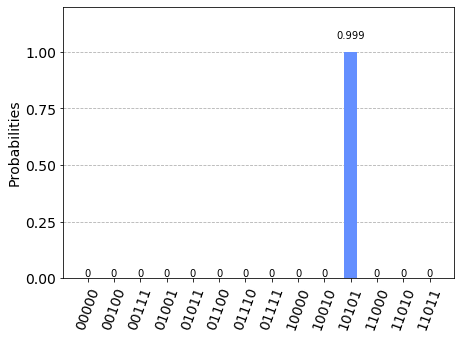

In [58]:
simulator = Aer.get_backend("qasm_simulator")
job = execute(circuit, backend=simulator, shots=2**15)
result = job.result()
counts = result.get_counts()
visualization.plot_histogram(counts)

In [59]:
most_frequent_solution = max(counts.items(), key=lambda x: x[1])[0]
print("Most Frequent Solution: {}".format(most_frequent_solution))
if most_frequent_solution == solution_string:
    print("Grover's algorithm found the solution!")
else:
    print("Grover's algorithm did not find the solution")

Most Frequent Solution: 10101
Grover's algorithm found the solution!


## Doing more than K iterations

It is important to notice that at exactly $K$ Grover iterations, the solution's amplitude has reached its maximum value. Thus, if we apply more iterations, it starts to decrease. We can verify that computationally.

Eventually, if more iterations are applied, the state will become $H^{\otimes n}|000...0\rangle$ again. Hence, it is important to find the right value of $K$, otherwise the probability of failing increases by a considerable margin.

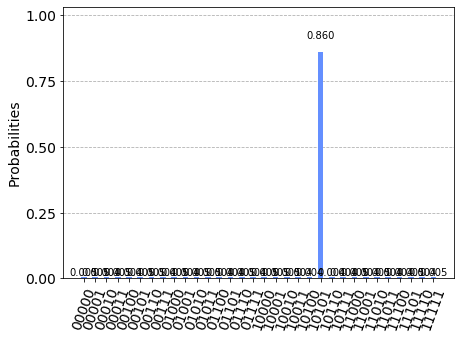

In [60]:
alt_circuit = QuantumCircuit(n+1, n)
alt_circuit.x(n)
alt_circuit.h(range(n+1))

grover_iteration(alt_circuit, solution_string, K+1)

alt_circuit.measure(
    list(range(n)),
    list(reversed(range(n)))
)

visualization.plot_histogram(
    execute(alt_circuit, backend=simulator, shots=2**15)
    .result()
    .get_counts()
)